# Выбор локации для скважины

Для нефтедобывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем необходимые библиотеки и функции, а также модели для обучения, настройки гиперпараметров и оценки качества и для работы с пайплайнами.

In [ ]:
import pandas as pd
#импортируем необходимые для проведения стат. анализа библиотеки
pd.options.display.float_format = '{:,.2f}'.format
!pip install --upgrade ipykernel -q
!pip install --upgrade pip  -q
!pip install matplotlib  -q
!pip -q install scikit-learn==1.6.1  -q
!pip install shap -q
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install ipython -q
!pip install phik -q
import time
from phik import phik_matrix  # Импорт функции phik_matrix
import phik
import random
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

# создание констант
RANDOM_STATE = 42
#Кол-во точек при разведке
boreholes = 500
#Кол-во лучших точек
best_place = 200
#10 млрд руб. выделено на разработку скважин в каждом регионе
summa = 10e9
#доход с каждой единицы продукта скважины
revenue_per_unit = 450e3
#Число выборок для Bootstrap
N_bootstrap = 1000

#импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt
import plotly.express as px

#импортируем библиотеку для построения более сложных графиков
import seaborn as sns

#импортируем библиотеку для работы с многомерными массивами
import numpy as np
import seaborn as sns

#импортируем библиотеку проведения статистического анализа (проведения стат. тестов и получения оценок рез-тов)
from scipy import stats as st

#функция для разделения данных
from sklearn.model_selection import train_test_split

#импортируем из библиотеки sklearn модели линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

#импортируем из библиотеки sklearn функции для оценки моделей машинного обучения.
from sklearn.metrics import mean_squared_error, confusion_matrix

from sklearn.utils import resample

# загружаем нужные классы
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

### Считываем данные из файлов изаписываем их в переменные.

In [ ]:
#Считываем файлы с данными и записываем датасеты в соответствующие переменные

#Данные геологоразведки 1-го региона
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv', engine = 'python', sep = ',')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep = ',')

#Данные геологоразведки 2-го региона
try:
    geo_data_1 = pd.read_csv('geo_data_1.csv', engine = 'python', sep = ',')
except:
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', sep = ',')

#Данные геологоразведки 3-го региона
try:
    geo_data_2 = pd.read_csv('geo_data_2.csv', engine = 'python', sep = ',')
except:
    geo_data_2= pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', sep = ',')

### Изучим общую информацию о данных в 3-х датасетах

In [ ]:
geo_data_0.info()
display (geo_data_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [ ]:
geo_data_1.info()
display (geo_data_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [ ]:
geo_data_2.info()
display (geo_data_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Пропусков в данных не обнаружено.

In [ ]:
#Проверим наличие явных дубликатов во всех датасетах
display (geo_data_0.duplicated().sum(), geo_data_1.duplicated().sum(), geo_data_2.duplicated().sum())

0

0

0

Явных дубликатов не обнаружено.

### Проведем исследовательский анализ данных

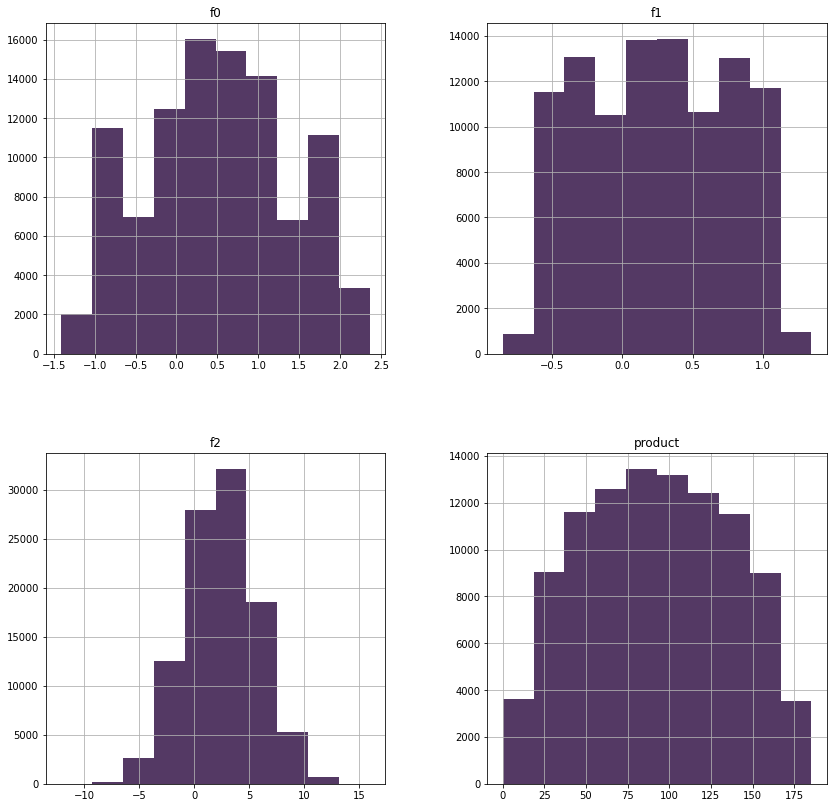

In [ ]:
#Первый датасет
geo_data_0.hist(figsize=(14, 14), color = '#543964');

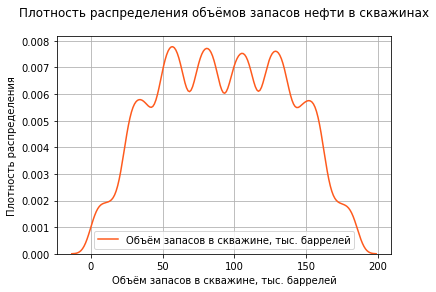

In [ ]:
# Построение KDE графика плотности распределения целевого признака
sns.kdeplot(geo_data_0['product'], color='#fe5a1d', label='Объём запасов в скважине, тыс. баррелей', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения объёмов запасов нефти в скважинах', pad=20)
plt.xlabel('Объём запасов в скважине, тыс. баррелей')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

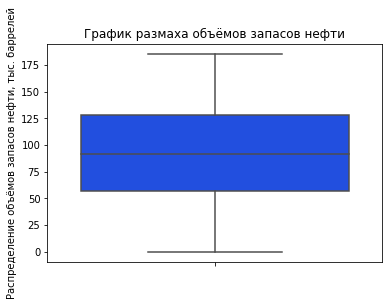

count   100,000.00
mean         92.50
std          44.29
min           0.00
25%          56.50
50%          91.85
75%         128.56
max         185.36
Name: product, dtype: float64

In [ ]:
#График размаха объёмов запасов нефти в скважине, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_0, y = 'product', palette="bright")
    .set(title = 'График размаха объёмов запасов нефти', ylabel = 'Распределение объёмов запасов нефти, тыс. баррелей'))
plt.show();

#Доп. инфо
geo_data_0['product'].describe()

**В первом регионе** среднее значение целевой переменной - 92.5 тыс. баррелей нефти, медианное - 91.85 , минимальное - 0, максимальное - 185.36. Выбросов и аномалей не найдено.

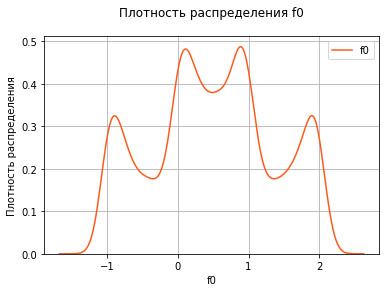

In [ ]:
# Построение KDE графика плотности распределения признака f0
sns.kdeplot(geo_data_0['f0'], color='#fe5a1d', label='f0', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f0', pad=20)
plt.xlabel('f0')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

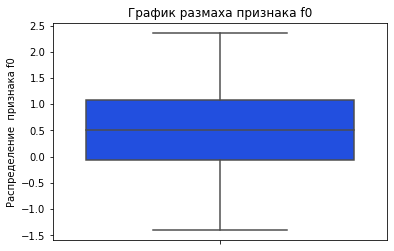

count   100,000.00
mean          0.50
std           0.87
min          -1.41
25%          -0.07
50%           0.50
75%           1.07
max           2.36
Name: f0, dtype: float64

In [ ]:
#График размаха признака f0, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_0, y = 'f0', palette="bright")
    .set(title = 'График размаха признака f0', ylabel = 'Распределение  признака f0'))
plt.show();

#Доп. инфо
geo_data_0['f0'].describe()

**В первом регионе** среднее значение признака **f0** - 0.5, медианное - 0.5 , минимальное - -1.41, максимальное - 2.36. Выбросов и аномалей не найдено.

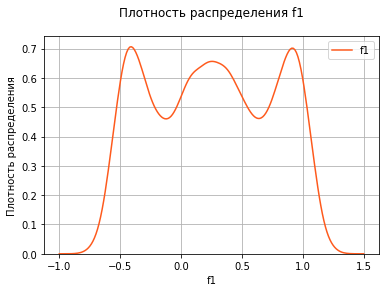

In [ ]:
# Построение KDE графика плотности распределения признака f1
sns.kdeplot(geo_data_0['f1'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f1', pad=20)
plt.xlabel('f1')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

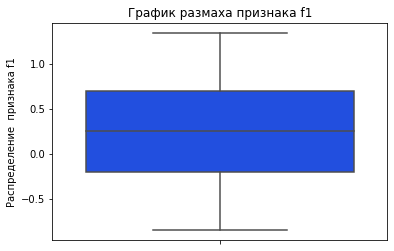

count   100,000.00
mean          0.25
std           0.50
min          -0.85
25%          -0.20
50%           0.25
75%           0.70
max           1.34
Name: f1, dtype: float64

In [ ]:
#График размаха признака f1, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_0, y = 'f1', palette="bright")
    .set(title = 'График размаха признака f1', ylabel = 'Распределение  признака f1'))
plt.show();

#Доп. инфо
geo_data_0['f1'].describe()

**В первом регионе** среднее значение признака **f1** - 0.25, медианное - 0.25 , минимальное - -0.85, максимальное - 1.34. Выбросов и аномалей не найдено.

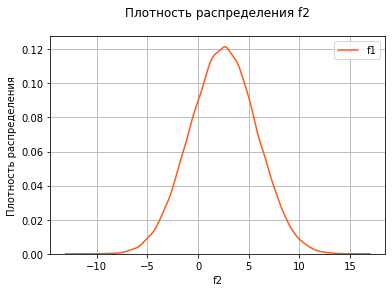

In [ ]:
# Построение KDE графика плотности распределения признака f2
sns.kdeplot(geo_data_0['f2'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f2', pad=20)
plt.xlabel('f2')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

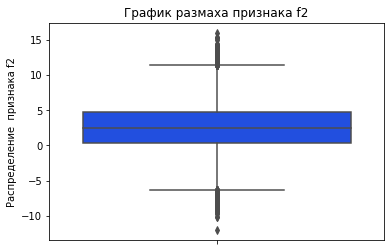

count   100,000.00
mean          2.50
std           3.25
min         -12.09
25%           0.29
50%           2.52
75%           4.72
max          16.00
Name: f2, dtype: float64

In [ ]:
#График размаха признака f2, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_0, y = 'f2', palette="bright")
    .set(title = 'График размаха признака f2', ylabel = 'Распределение  признака f2'))
plt.show();

#Доп. инфо
geo_data_0['f2'].describe()

**В первом регионе** среднее значение признака **f2** - 2.5, медианное - 2.52 , минимальное - -12.09, максимальное - 16. Обнаружены выбросы в признаке f2.

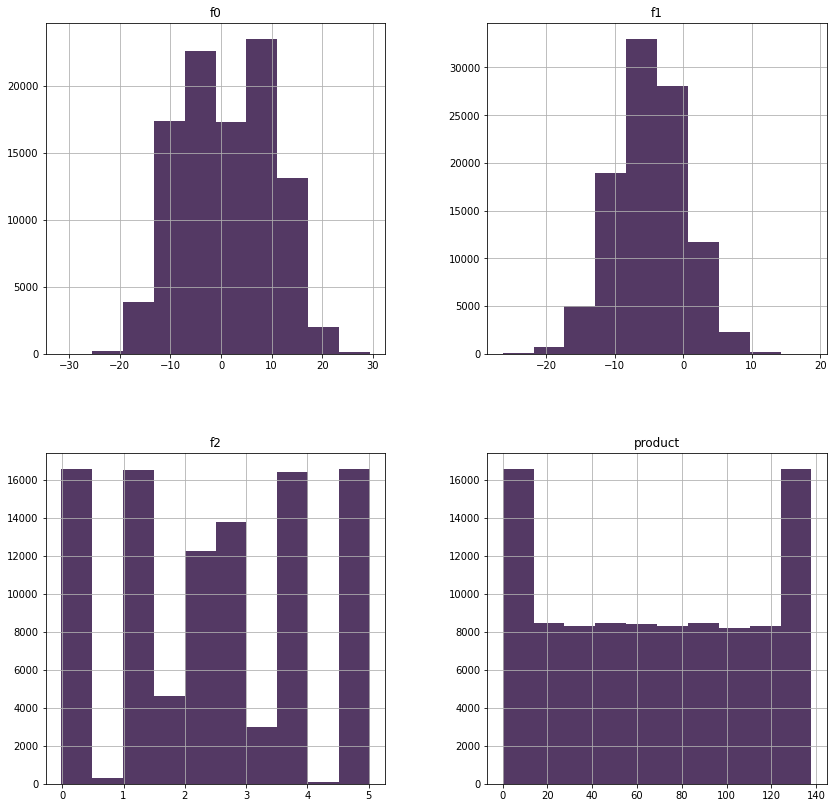

In [ ]:
geo_data_1.hist(figsize=(14, 14), color = '#543964');

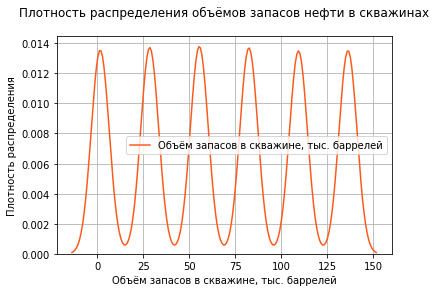

In [ ]:
# Построение KDE графика плотности распределения целевого признака
sns.kdeplot(geo_data_1['product'], color='#fe5a1d', label='Объём запасов в скважине, тыс. баррелей', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения объёмов запасов нефти в скважинах', pad=20)
plt.xlabel('Объём запасов в скважине, тыс. баррелей')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

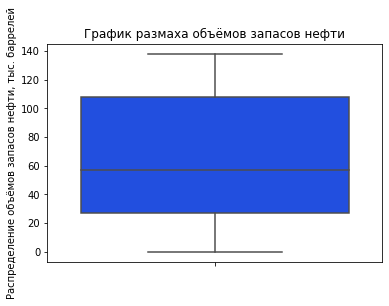

count   100,000.00
mean         68.83
std          45.94
min           0.00
25%          26.95
50%          57.09
75%         107.81
max         137.95
Name: product, dtype: float64

In [ ]:
#График размаха объёмов запасов нефти в скважине, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_1, y = 'product', palette="bright")
    .set(title = 'График размаха объёмов запасов нефти', ylabel = 'Распределение объёмов запасов нефти, тыс. баррелей'))
plt.show();

#Доп. инфо
geo_data_1['product'].describe()

**Во втором регионе** среднее значение целевой переменной - 68.83 тыс. баррелей нефти, медианное - 57.09 , минимальное - 0, максимальное - 137.95. Выбросов и аномалей не найдено.

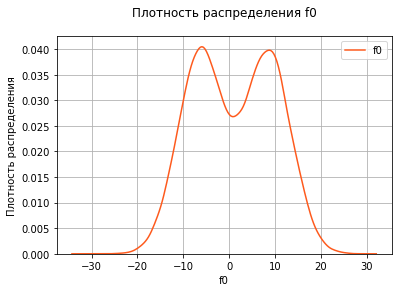

In [ ]:
# Построение KDE графика плотности распределения признака f0
sns.kdeplot(geo_data_1['f0'], color='#fe5a1d', label='f0', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f0', pad=20)
plt.xlabel('f0')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

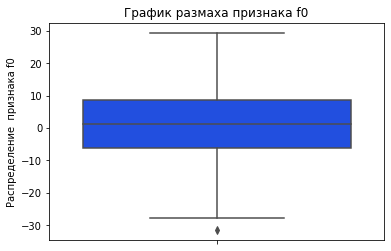

count   100,000.00
mean          1.14
std           8.97
min         -31.61
25%          -6.30
50%           1.15
75%           8.62
max          29.42
Name: f0, dtype: float64

In [ ]:
#График размаха признака f0, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_1, y = 'f0', palette="bright")
    .set(title = 'График размаха признака f0', ylabel = 'Распределение  признака f0'))
plt.show();

#Доп. инфо
geo_data_1['f0'].describe()

**Во втором регионе** среднее значение признака **f0** - 1.14, медианное - 1.15 , минимальное - -31.61, максимальное - 29.42. Выброс- минимальное значение.

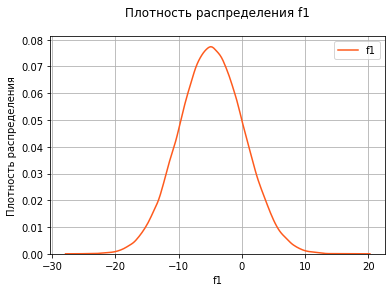

In [ ]:
# Построение KDE графика плотности распределения признака f1
sns.kdeplot(geo_data_1['f1'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f1', pad=20)
plt.xlabel('f1')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

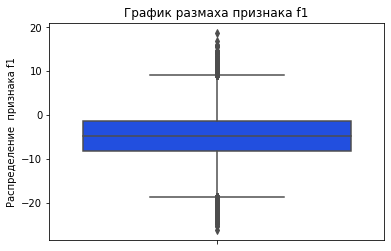

count   100,000.00
mean         -4.80
std           5.12
min         -26.36
25%          -8.27
50%          -4.81
75%          -1.33
max          18.73
Name: f1, dtype: float64

In [ ]:
#График размаха признака f1, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_1, y = 'f1', palette="bright")
    .set(title = 'График размаха признака f1', ylabel = 'Распределение  признака f1'))
plt.show();

#Доп. инфо
geo_data_1['f1'].describe()

**Во втором регионе** среднее значение признака **f1** - -4.8, медианное - -4.81 , минимальное - -26.36, максимальное - 18.73. Выбросы обнаружены.


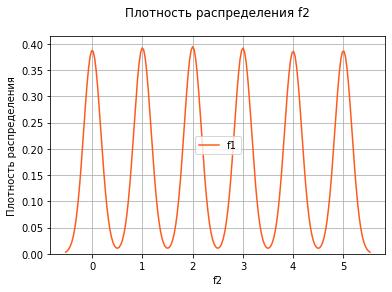

In [ ]:
# Построение KDE графика плотности распределения признака f2
sns.kdeplot(geo_data_1['f2'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f2', pad=20)
plt.xlabel('f2')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

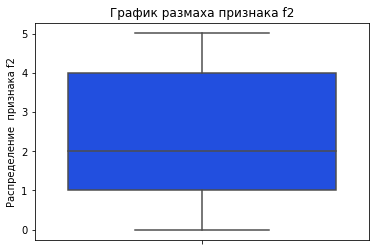

count   100,000.00
mean          2.49
std           1.70
min          -0.02
25%           1.00
50%           2.01
75%           4.00
max           5.02
Name: f2, dtype: float64

In [ ]:
#График размаха признака f2, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_1, y = 'f2', palette="bright")
    .set(title = 'График размаха признака f2', ylabel = 'Распределение  признака f2'))
plt.show();

#Доп. инфо
geo_data_1['f2'].describe()


**Во втором регионе** среднее значение признака **f2** - 2.49, медианное - 2.01 , минимальное - -0.02, максимальное - 5.02. Выбросов и аномалей не найдено.

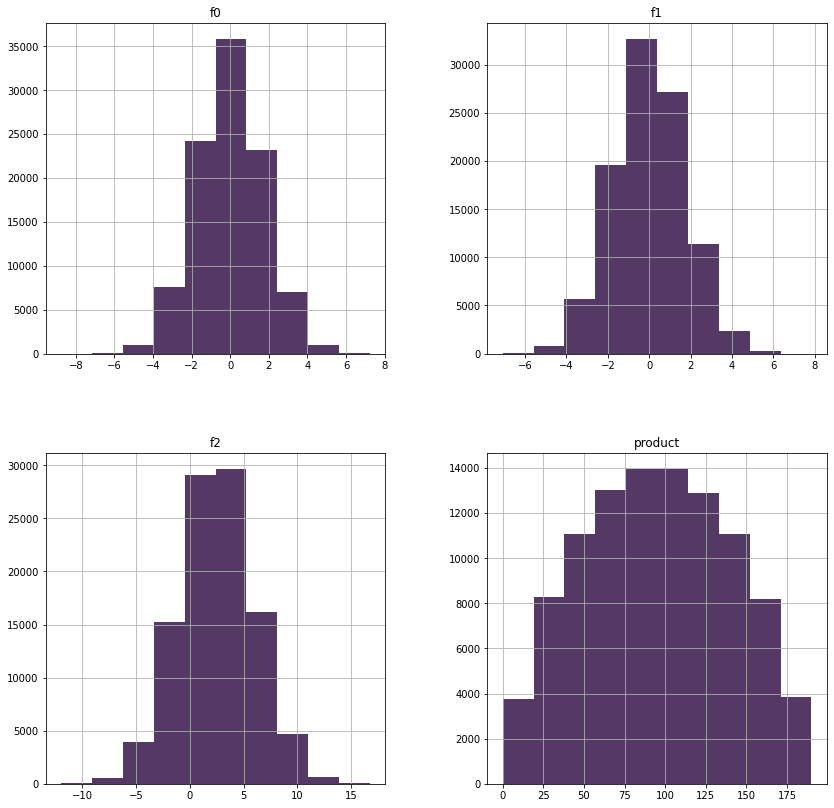

In [ ]:
geo_data_2.hist(figsize=(14, 14), color = '#543964');

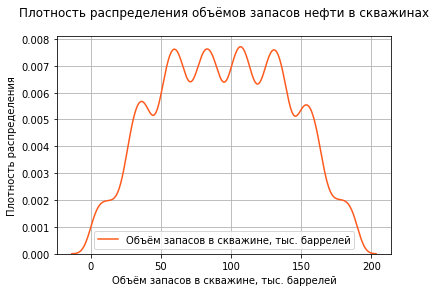

In [ ]:
# Построение KDE графика плотности распределения целевого признака
sns.kdeplot(geo_data_2['product'], color='#fe5a1d', label='Объём запасов в скважине, тыс. баррелей', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения объёмов запасов нефти в скважинах', pad=20)
plt.xlabel('Объём запасов в скважине, тыс. баррелей')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

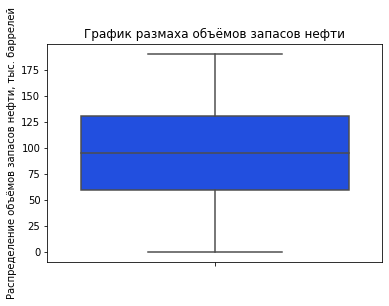

count   100,000.00
mean         95.00
std          44.75
min           0.00
25%          59.45
50%          94.93
75%         130.60
max         190.03
Name: product, dtype: float64

In [ ]:
#График размаха объёмов запасов нефти в скважине, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_2, y = 'product', palette="bright")
    .set(title = 'График размаха объёмов запасов нефти', ylabel = 'Распределение объёмов запасов нефти, тыс. баррелей'))
plt.show();

#Доп. инфо
geo_data_2['product'].describe()

**В третьем регионе** среднее значение целевой переменной - 95 тыс. баррелей нефти, медианное - 94.93 , минимальное - 0, максимальное - 190.03. Выбросов и аномалей не найдено.

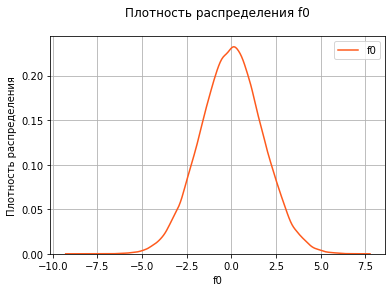

In [ ]:
# Построение KDE графика плотности распределения признака f0
sns.kdeplot(geo_data_2['f0'], color='#fe5a1d', label='f0', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f0', pad=20)
plt.xlabel('f0')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

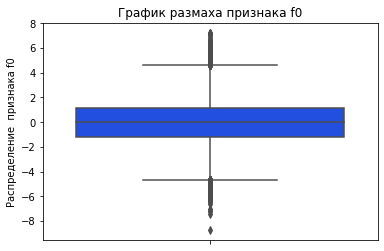

count   100,000.00
mean          0.00
std           1.73
min          -8.76
25%          -1.16
50%           0.01
75%           1.16
max           7.24
Name: f0, dtype: float64

In [ ]:
#График размаха признака f0, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_2, y = 'f0', palette="bright")
    .set(title = 'График размаха признака f0', ylabel = 'Распределение  признака f0'))
plt.show();

#Доп. инфо
geo_data_2['f0'].describe()

**В третьем регионе** среднее значение признака **f0** - 0, медианное - 0.01 , минимальное - -8.76, максимальное - 7.24. Выбросы найдены.

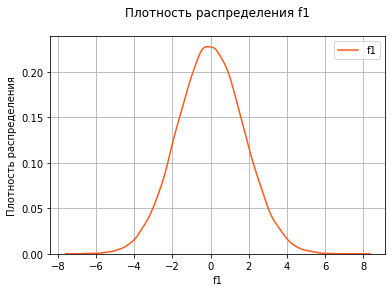

In [ ]:
# Построение KDE графика плотности распределения признака f1
sns.kdeplot(geo_data_2['f1'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f1', pad=20)
plt.xlabel('f1')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

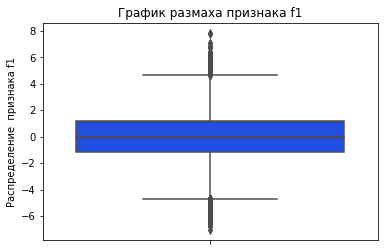

count   100,000.00
mean         -0.00
std           1.73
min          -7.08
25%          -1.17
50%          -0.01
75%           1.16
max           7.84
Name: f1, dtype: float64

In [ ]:
#График размаха признака f1, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_2, y = 'f1', palette="bright")
    .set(title = 'График размаха признака f1', ylabel = 'Распределение  признака f1'))
plt.show();

#Доп. инфо
geo_data_2['f1'].describe()

**В третьем регионе** среднее значение признака **f1** - 0, медианное - -0.01 , минимальное - -7.08, максимальное - 7.84. Выбросы найдены.

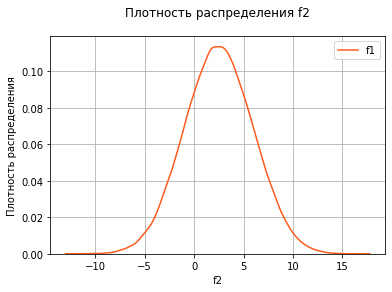

In [ ]:
# Построение KDE графика плотности распределения признака f2
sns.kdeplot(geo_data_2['f2'], color='#fe5a1d', label='f1', alpha=0.5)

# Настройка графика
plt.legend(loc='best')
plt.title('Плотность распределения f2', pad=20)
plt.xlabel('f2')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show();

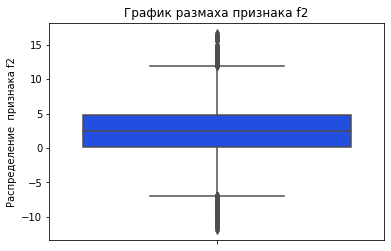

count   100,000.00
mean          2.50
std           3.47
min         -11.97
25%           0.13
50%           2.48
75%           4.86
max          16.74
Name: f2, dtype: float64

In [ ]:
#График размаха признака f2, чтобы выявить выбросы/аномалии
(sns.boxplot(data = geo_data_2, y = 'f2', palette="bright")
    .set(title = 'График размаха признака f2', ylabel = 'Распределение  признака f2'))
plt.show();

#Доп. инфо
geo_data_2['f2'].describe()

**В третьем регионе** среднее значение признака **f2** - 2.5, медианное - -2.45 , минимальное - -11.97, максимальное - 16.74. Выбросы найдены.

Проведем корреляционный анализ

In [ ]:
pip show phik

Name: phik
Version: 0.12.4
Summary: Phi_K correlation analyzer library
Home-page: 
Author: 
Author-email: KPMG N.V. The Netherlands <kave@kpmg.com>
License: 
Location: /opt/conda/lib/python3.9/site-packages
Requires: joblib, matplotlib, numpy, pandas, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Корреляционный анализ

interval columns not set, guessing: ['product', 'f0', 'f1', 'f2']
interval columns not set, guessing: ['product', 'f0', 'f1', 'f2']
interval columns not set, guessing: ['product', 'f0', 'f1', 'f2']


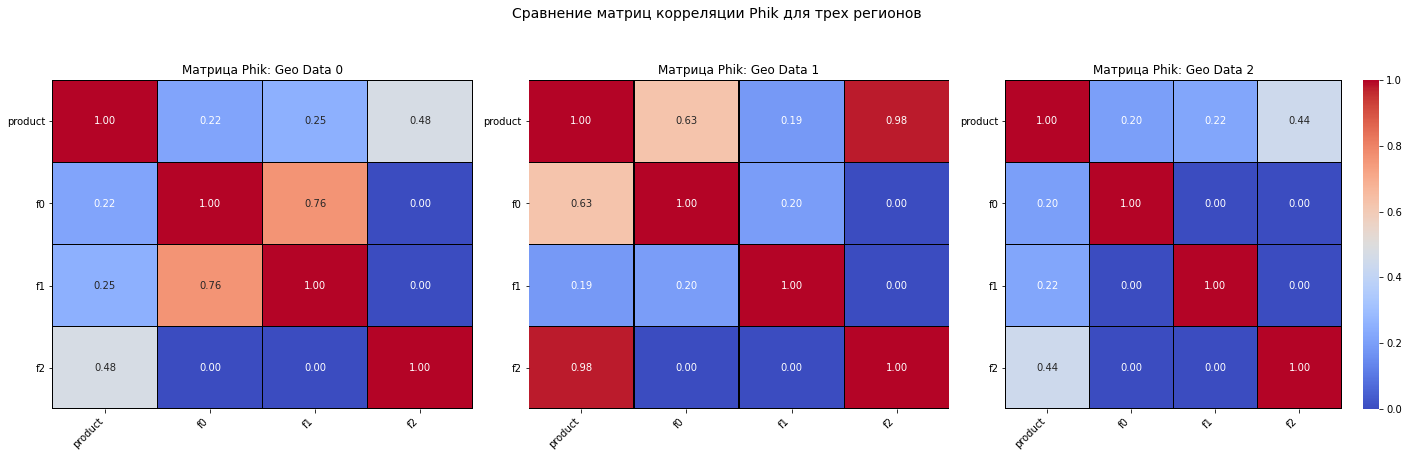

In [ ]:
#Удалим столбец с id из датасетов, чтобы провести корреляционный анализ
geo_data_0_copy = geo_data_0.copy()
geo_data_0_copy = geo_data_0_copy.drop(columns=['id'])

geo_data_1_copy = geo_data_1.copy()
geo_data_1_copy = geo_data_1_copy.drop(columns=['id'])

geo_data_2_copy = geo_data_2.copy()
geo_data_2_copy = geo_data_2_copy.drop(columns=['id'])

# Список непрерывных признаков
interval_columns = ['product', 'f0', 'f1', 'f2']

# Создаем фигуру с 3 подграфиками
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Список датасетов
datasets = [geo_data_0_copy, geo_data_1_copy, geo_data_2_copy]
titles = ['Geo Data 0', 'Geo Data 1', 'Geo Data 2']

# Для каждого датасета строим heatmap
for i, (data, title) in enumerate(zip(datasets, titles)):
    # Вычисляем матрицу phik
    matrix = data[interval_columns].phik_matrix()
    # Строим тепловую карту
    sns.heatmap(matrix,
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                cbar=i==2,
                linewidths=0.2,
                linecolor="black",
                ax=axes[i])
    # Настройки подграфика
    axes[i].set_title(f'Матрица Phik: {title}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

fig.suptitle('Сравнение матриц корреляции Phik для трех регионов', y=1.05, fontsize=14)
plt.tight_layout()
plt.show();

**Из корреляционного анализа можно сделать следующие выводы**:
- В первом регионе обнаружена сильная положительная взаимосвязь между признаками f1 и f0, а также между целевым признаком и f2  
- Во втором регионе обнаружена сильная положительная взаимосвязь между целевым признаком и f2, а также целевым и f0  
- Во третьем регионе обнаружена положительная взаимосвязь между целевым признаком и f2  

**Выводы:**

В ходе первого этапа работы над проектом данные о нефтяных месторождениях по трем регонам были загружены данные в три датасета.
   
Названия характеристик месторождений соответствуют стилю, принятому в Python.  
Дубликаты ни в одном из датасетах не обнаружены. Пропусков также не найдено.  
Типы данных соответствуют данным в датасетах.  Категориальных данных в датасетах нет.

В ходе второго этапа проведен исследовательский и корреляционный анализ данных.   
В данных нескольких датасетов были найдены выбросы.   По тепловой карте корреляционной матрице найдены сильные линейные зависимости между данными в датасетах.   

## Обучение и проверка модели

По условиям проекта для прогноза целевого признака будет использована модель машинного обучения на основе линейной регрессии.

In [ ]:
# Инициализируем списки для хранения результатов
predictions_valid = []  # список предсказаний
true_target = []        # список правильных ответов (тренировочные)
targets_valid = []      # список правильных ответов (валидационные)
predictions_mean = []   # список средних предсказаний
result_datasets = []    # список для хранения результирующих датасетов

def work_with_dataset(df, region_num):
    # Разделяем входные признаки и целевую переменную
    features = df.drop(["product"], axis=1)
    target = df["product"]

    # Разделяем данные на тренировочные и валидационные
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state = RANDOM_STATE)

    # Создаём и обучаем модель
    model = LinearRegression()
    model.fit(features_train, target_train)

    # Делаем предсказания
    predictions = model.predict(features_valid)

    # Сохраняем результаты
    predictions_valid.append(predictions)
    true_target.append(target_train.reset_index(drop=True))
    targets_valid.append(target_valid.reset_index(drop=True))
    predictions_mean.append(round(predictions.mean(), 0))

    # Создаем датафрейм с реальными и предсказанными значениями
    result_df = pd.DataFrame({
        'product': target_valid.values,
        'predict': predictions
    })
    result_datasets.append(result_df)

    # Выводим метрику
    display(f"Регион № {region_num}:")
    display("Средний запас предсказанного сырья: {0:.1f} тыс. баррелей".format(predictions.mean()))
    display("RMSE модели: {0:.1f}".format(np.sqrt(mean_squared_error(target_valid, predictions))))
    display("Пример данных:")
    display(result_df.head())

# Список датасетов для обработки
datasets = [geo_data_0_copy, geo_data_1_copy, geo_data_2_copy]

# Обрабатываем каждый датасет
for i, dataset in enumerate(datasets, 1):
    work_with_dataset(dataset, i)

'Регион № 1:'

'Средний запас предсказанного сырья: 92.4 тыс. баррелей'

'RMSE модели: 37.8'

'Пример данных:'

,product,predict
0,122.07,101.90
1,48.74,78.22
2,131.34,115.27
3,88.33,105.62
4,36.96,97.98


'Регион № 2:'

'Средний запас предсказанного сырья: 68.7 тыс. баррелей'

'RMSE модели: 0.9'

'Пример данных:'

,product,predict
0,0.00,0.84
1,53.91,52.92
2,134.77,135.11
3,107.81,109.49
4,0.00,-0.05


'Регион № 3:'

'Средний запас предсказанного сырья: 94.8 тыс. баррелей'

'RMSE модели: 40.1'

'Пример данных:'

,product,predict
0,117.44,98.30
1,47.84,101.59
2,45.88,52.45
3,139.01,109.92
4,84.00,72.41


In [ ]:
# Данные по регионам
region1_results = result_datasets[0]  # Регион 1
region2_results = result_datasets[1]  # Регион 2
region3_results = result_datasets[2]  # Регион 3

display (region1_results, region2_results, region3_results)

,product,predict
0,122.07,101.90
1,48.74,78.22
2,131.34,115.27
3,88.33,105.62
4,36.96,97.98
...,...,...
24995,148.82,105.08
24996,123.45,74.77
24997,91.95,82.54
24998,149.30,81.83


,product,predict
0,0.00,0.84
1,53.91,52.92
2,134.77,135.11
3,107.81,109.49
4,0.00,-0.05
...,...,...
24995,107.81,108.35
24996,53.91,53.60
24997,26.95,26.71
24998,110.99,109.82


,product,predict
0,117.44,98.30
1,47.84,101.59
2,45.88,52.45
3,139.01,109.92
4,84.00,72.41
...,...,...
24995,40.80,102.76
24996,87.14,93.43
24997,52.04,64.10
24998,136.96,83.76


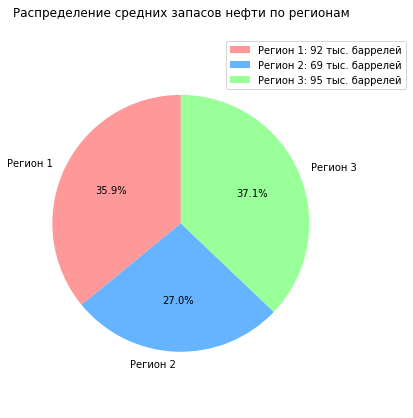

In [ ]:
# Данные средних запасов по регионам
regions = ['Регион 1', 'Регион 2', 'Регион 3']
mean_reserves = predictions_mean  # список со средними запасами

# Создаем круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(mean_reserves,
        labels=regions,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff','#99ff99']
        )
plt.title('Распределение средних запасов нефти по регионам', pad=20)
legend_labels = [f'{region}: {mean:.0f} тыс. баррелей'
                 for region, mean in zip(regions, mean_reserves)]
plt.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.axis('equal')
plt.tight_layout()
plt.show();

**Выводы:**
1. Подготовка данных и моделирование:    

Все исходные данные были разделены на обучающую (75%) и валидационную (25%) выборки.  
Для каждого региона построены и обучены модели линейной регрессии.  
Выполнены прогнозы объёмов сырья для валидационных выборок.  

2. Результаты по регионам:  

Сформированы массивы прогнозов и фактических значений для каждого региона.  

3. Оценка точности моделей:  

Регион 2 демонстрирует аномально низкую RMSE (0.89), что, вероятно, связано с:  
полной линейной зависимостью (корреляция ~ 1.0) между признаком f2 и целевой переменной и возможным переобучением модели  

Регионы 1 и 3 показывают существенно более высокие значения RMSE:  
- Регион 1: 37.58  
- Регион 3: 39.96  

Такие показатели свидетельствуют о значительном разбросе данных в валидационных выборках  

4. Анализ прогнозируемых запасов:  

- Регион 2 имеет минимальные прогнозируемые запасы - всего 69 тыс. баррелей  
- Для Регионов 1 и 3 этот показатель составляет 93-95 тыс. баррелей, что на ~35% выше  

Выявленные особенности:  

- Модель для Региона 2 требует дополнительной проверки на адекватность  

- Для Регионов 1 и 3 необходимо исследовать причины высокого RMSE:  

Возможна нелинейная зависимость  
Требуется дополнительная предобработка данных  
Может потребоваться выбор другой модели   

In [ ]:
geo_data_1_copy1 = geo_data_1.copy()

#Новый столбец с вычислением f2/f1
geo_data_1_copy1['f2_f1'] = geo_data_1_copy['f2'] / geo_data_1_copy['f1']

#Удаляем исходные столбцы и проверяем результат
geo_data_1_copy1.drop(columns=['f2', 'f1', 'id'], inplace=True)
display (geo_data_1_copy1.head())

,f0,product,f2_f1
0,-15.00,3.18,0.00
1,14.27,26.95,-0.29
2,6.26,134.77,-0.84
3,-13.08,137.95,-0.43
4,12.70,134.77,-0.61


In [ ]:
work_with_dataset(geo_data_1_copy1, 2)

'Регион № 2:'

'Средний запас предсказанного сырья: 68.8 тыс. баррелей'

'RMSE модели: 45.9'

'Пример данных:'

,product,predict
0,0.00,68.08
1,53.91,66.43
2,134.77,67.92
3,107.81,69.07
4,0.00,66.93


RMSE модели по 2-му региону увеличился - 46. Переобучения нет.

## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

In [ ]:
regions = ['Регионе 1', 'Регионе 2', 'Регионе 3']
datasets = [geo_data_0_copy, geo_data_1_copy1, geo_data_0_copy]

break_even = summa / (revenue_per_unit * best_place)
display (f'Минимально необходимый запас нефти в скважине для окупаемости ее разработки = {break_even:.1f} тыс. баррелей.')

for regions, datasets in zip(regions, datasets):
    display()
    display(f'Средний запас нефти в скважинах {regions} = {datasets["product"].mean():.1f} тыс. баррелей.')
    display(f'- Доля скважин с запасами нефти больше, чем пороговое значение = {len(datasets.query("product > @break_even")) / len(datasets):.1%}')
    display(f'- Число скважин с запасами нефти больше, чем пороговое значение = {len(datasets.query("product > @break_even"))}')

'Минимально необходимый запас нефти в скважине для окупаемости ее разработки = 111.1 тыс. баррелей.'

'Средний запас нефти в скважинах Регионе 1 = 92.5 тыс. баррелей.'

'- Доля скважин с запасами нефти больше, чем пороговое значение = 36.6%'

'- Число скважин с запасами нефти больше, чем пороговое значение = 36583'

'Средний запас нефти в скважинах Регионе 2 = 68.8 тыс. баррелей.'

'- Доля скважин с запасами нефти больше, чем пороговое значение = 16.5%'

'- Число скважин с запасами нефти больше, чем пороговое значение = 16537'

'Средний запас нефти в скважинах Регионе 3 = 92.5 тыс. баррелей.'

'- Доля скважин с запасами нефти больше, чем пороговое значение = 36.6%'

'- Число скважин с запасами нефти больше, чем пороговое значение = 36583'

3.3. Напишите выводы по этапу подготовки расчёта прибыли.

**Выводы из расчета окупаемости проекта по разработке нефтяных месторождений**   
Экономическая целесообразность разработки требует отбора скважин с запасами, которые значительно превышающими установленный средний порог.  
Нужно учитывать, что:
- точка безубыточности составляет в среднем 111 тыс. баррелей на скважину   
- средние запасы по регионам варьируются в диапазоне 69 - 92 тыс. баррелей   

Выбор высокопродуктивных объектов становится ключевым фактором окупаемости инвестиций.

## Расчёт прибыли и рисков

4.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [ ]:
def calculate_profit(wells_df, revenue_per_unit, summa=summa):
    wells = wells_df.copy()
    wells['profit'] = wells['product'] * revenue_per_unit
    total_profit = wells['profit'].sum() - summa
    return wells, total_profit

def select_and_calculate_profit(region1_results, region2_results, region3_results,
                               revenue_per_unit, best_place=best_place, summa=summa):

#Регион №1
    top_region1 = region1_results.nlargest(best_place, 'predict')
    wells1, profit1 = calculate_profit(top_region1, revenue_per_unit, summa)

#Регион №2
    top_region2 = region2_results.nlargest(best_place, 'predict')
    wells2, profit2 = calculate_profit(top_region2, revenue_per_unit, summa)

#Регион №3
    top_region3 = region3_results.nlargest(best_place, 'predict')
    wells3, profit3 = calculate_profit(top_region3, revenue_per_unit, summa)

#Вывод результатов
    print(f'Регион 1: Суммарная прибыль топ-{best_place} скважин = {profit1:,.0f} руб.')
    print(f'Регион 2: Суммарная прибыль топ-{best_place} скважин = {profit2:,.0f} руб.')
    print(f'Регион 3: Суммарная прибыль топ-{best_place} скважин = {profit3:,.0f} руб.')

    return wells1, wells2, wells3

In [ ]:
top1, top2, top3 = select_and_calculate_profit(
    region1_results,
    region2_results,
    region3_results,
    revenue_per_unit,
    best_place,
    summa)

Регион 1: Суммарная прибыль топ-200 скважин = 3,359,141,114 руб.
Регион 2: Суммарная прибыль топ-200 скважин = 2,415,086,697 руб.
Регион 3: Суммарная прибыль топ-200 скважин = 2,598,571,759 руб.


4.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [ ]:
def profit(target, predictions, n_bootstrap=N_bootstrap, revenue_per_unit=revenue_per_unit, fixed_costs=summa):
    combined = pd.DataFrame({'target': target, 'predict': predictions})
    top_wells = combined.nlargest(best_place, 'predict')
    return ((top_wells['target'] * revenue_per_unit).sum()- fixed_costs) / 1_000_000

def bootstrap(target, predict, n_samples):
    state = np.random.RandomState(RANDOM_STATE)
    profits = []

    for _ in tqdm(range(N_bootstrap), desc='Bootstrap итерации'):
        idx = state.choice(len(target), size=n_samples, replace=True)
        target_subsample = target.iloc[idx]
        probs_subsample = predict.iloc[idx]
        profits.append(profit(target_subsample, probs_subsample, best_place))

    profits = pd.Series(profits)
    risk = (profits < 0).mean()

    return {
        'mean_profit': profits.mean(),
        'ci_95': (profits.quantile(0.025), profits.quantile(0.975)),
        'risk': risk,
        'profits': profits
    }
#Функция для анализ регионов с bootstrap
def analyze_regions(targets, predictions, sample_size=boreholes):
    results = []
    risk_values = []

    for i in range(3):
        display(f'Анализ региона {i+1}:')
        region_results = bootstrap(targets[i], predictions[i], sample_size)
        results.append({
            'Регион': f'Регион {i+1}',
            'Средняя прибыль (млн руб.)': f'{region_results["mean_profit"]:.2f}',
            '95% ДИ (млн руб.)': f'{region_results["ci_95"][0]:.2f} - {region_results["ci_95"][1]:.2f}',
            'Риск убытков (%)': f'{region_results["risk"]:.1%}'
        })

        risk_values.append(region_results["risk"] * 100)
        display(f'Средняя прибыль: {region_results["mean_profit"]:.2f} млн руб.')
        display(f'95% ДИ: [{region_results["ci_95"][0]:.2f}, {region_results["ci_95"][1]:.2f}] млн руб.')
        display(f'Риск убытков: {region_results["risk"]:.1%}')

    plot_risk_distribution(risk_values)
    return pd.DataFrame(results)

In [ ]:
# Визуализация рисков по регионам
def plot_risk_distribution(risk_values):
    plt.figure(figsize=(10, 6))
    colors = ['purple', 'green', 'orange']
    regions = ['Регион №1', 'Регион №2', 'Регион №3']
    bars = plt.bar(regions, risk_values, color=colors)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom',
                fontdict={'fontweight': boreholes, 'size': 12})
    plt.title("Риск убытков при разработке скважин", fontsize=14, pad=20)
    plt.ylabel('Риск, %', fontsize=12)
    plt.show()

'Анализ региона 1:'

Bootstrap итерации: 100%|██████████| 1000/1000 [00:01<00:00, 550.43it/s]


'Средняя прибыль: 399.58 млн руб.'

'95% ДИ: [-110.47, 897.46] млн руб.'

'Риск убытков: 6.0%'

'Анализ региона 2:'

Bootstrap итерации: 100%|██████████| 1000/1000 [00:01<00:00, 531.72it/s]


'Средняя прибыль: 452.05 млн руб.'

'95% ДИ: [61.68, 845.34] млн руб.'

'Риск убытков: 1.5%'

'Анализ региона 3:'

Bootstrap итерации: 100%|██████████| 1000/1000 [00:01<00:00, 546.42it/s]


'Средняя прибыль: 375.01 млн руб.'

'95% ДИ: [-144.77, 888.39] млн руб.'

'Риск убытков: 8.0%'

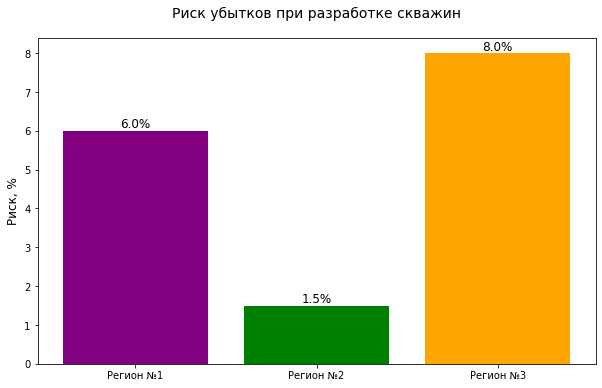

,Регион,Средняя прибыль (млн руб.),95% ДИ (млн руб.),Риск убытков (%)
0,Регион 1,399.58,-110.47 - 897.46,6.0%
1,Регион 2,452.05,61.68 - 845.34,1.5%
2,Регион 3,375.01,-144.77 - 888.39,8.0%


In [ ]:
if __name__ == "__main__":
    test_targets = [
        region1_results['product'],
        region2_results['product'],
        region3_results['product']]
    test_predictions = [
        region1_results['predict'],
        region2_results['predict'],
        region3_results['predict']]
    results_df = analyze_regions(test_targets, test_predictions)
    display(results_df)

5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

**Результаты анализа:**
✓ Был расчитан уровень риска по всем трем регионам при разработке 500 месторождений:  
- 6% в первом регионе с учетом средней прибыли в 400 млн.руб.   
- 1.5% во втором регионе с учетом средней прибыли в 452 млн.руб.  
- 8% в третьем регионе с учетом средней прибыли в 375 млн.руб.   

✓ Регион №2 с минимальным уровнем риска и самым лучшим показателем средней прибыли.  
✓ Регион № 3 - самый рискованный для разработки и показывает меньшую среднюю прибыль.

## **Итоговый Вывод:**   
## Результаты анализа трёх регионов

### Сравнительный анализ прибыльности:

#### Регион №2 - **РЕКОМЕНДУЕМЫЙ**:
- **Прибыльность**: Самая высокая средняя прибыль
- **Риски**: Минимальный уровень риска потерь
- **Стабильность**: Наиболее предсказуемые результаты

#### Регион №1:
- **Прибыльность**: Средние показатели доходности
- **Риски**: Умеренный уровень риска
- **Потенциал**: Возможен для рассмотрения при диверсификации

#### Регион №3 - **НЕ РЕКОМЕНДУЕТСЯ**:
- **Прибыльность**: Самая низкая средняя прибыль
- **Риски**: Максимальный уровень риска
- **Стабильность**: Высокая волатильность результатов

## Анализ прибыли по объёмам разработки

### Для 200 лучших месторождений:
- **Регион 2**: Оптимальное соотношение прибыли и риска
- **Регион 1**: Приемлемые показатели с повышенным риском
- **Регион 3**: Низкая прибыль при высоких рисках

### Для 500 лучших месторождений:
- **Регион 2**: Сохраняет лидерство по прибыльности
- **Регион 1**: Увеличивается разрыв с лидером
- **Регион 3**: Риски превышают потенциальную выгоду

## Рекомендации для компании «ГлавРосГосНефть»

### Приоритетная стратегия:
**Разработка в Регионе №2** - оптимальное решение по критериям:
-  **Максимальная прибыль** - наивысшая доходность инвестиций
-  **Минимальные риски** - стабильные и предсказуемые результаты
-  **Эффективность бюджета** - лучшее использование выделенных средств
